In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product h.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_h= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_h.shape

(60, 1)

In [5]:
sales_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_h['Sales'].sum()

4057933

Text(0.5, 1.0, 'Product H')

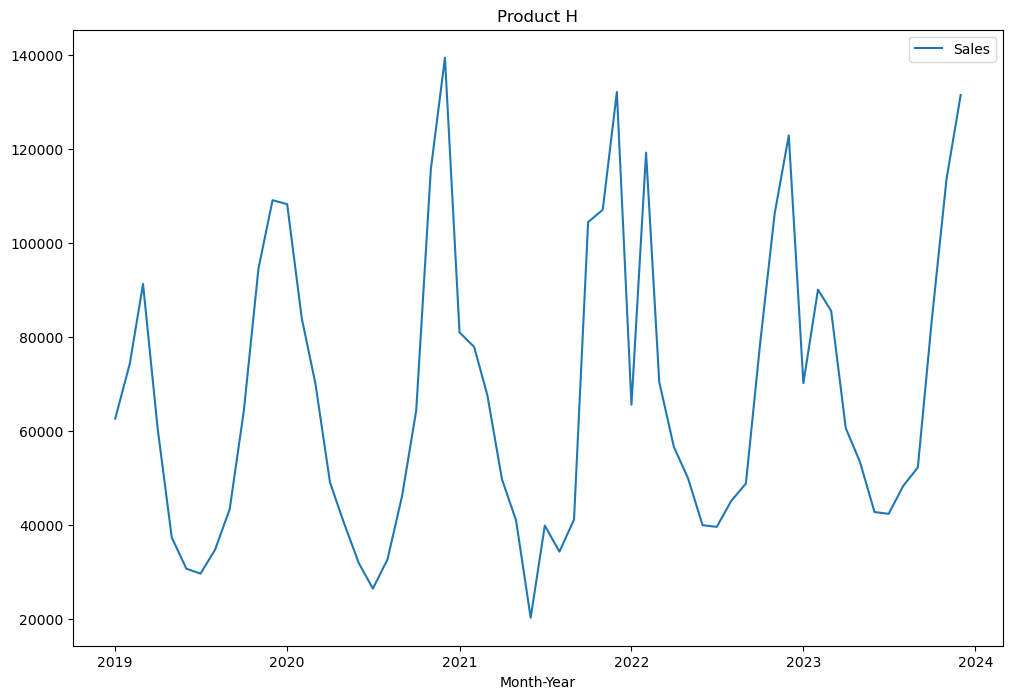

In [7]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h)
plt.title('Product H')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_h)

ADF Statistics: -1.0256008967536312
p- value: 0.7438128320877682
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_h_diff= sales_h.diff().dropna()

Text(0.5, 1.0, 'Product H- First Difference')

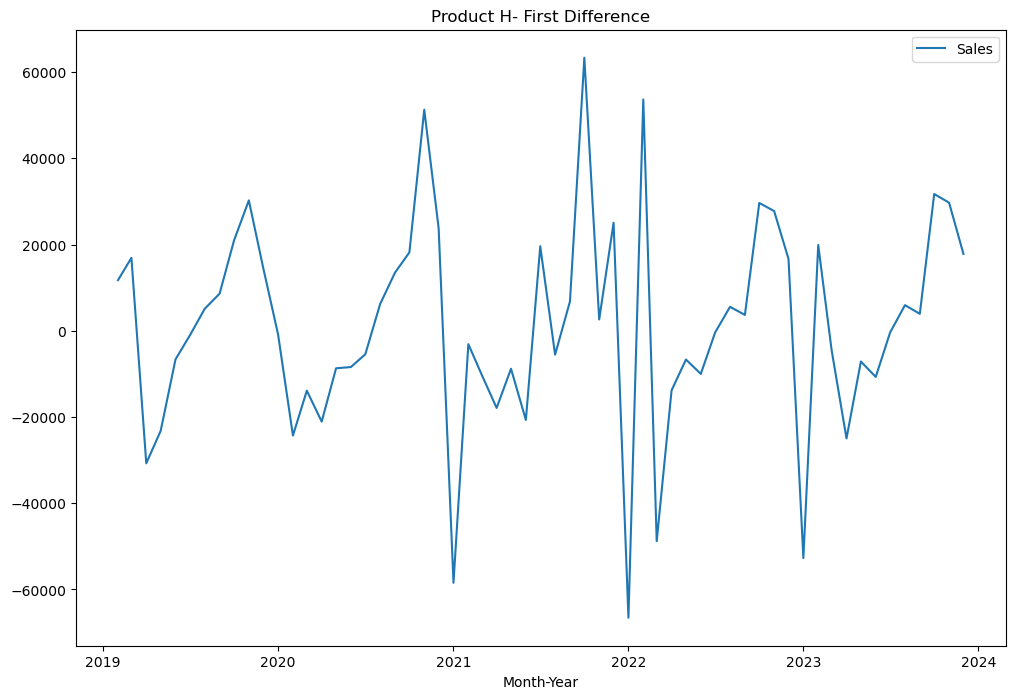

In [11]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h_diff)
plt.title('Product H- First Difference')

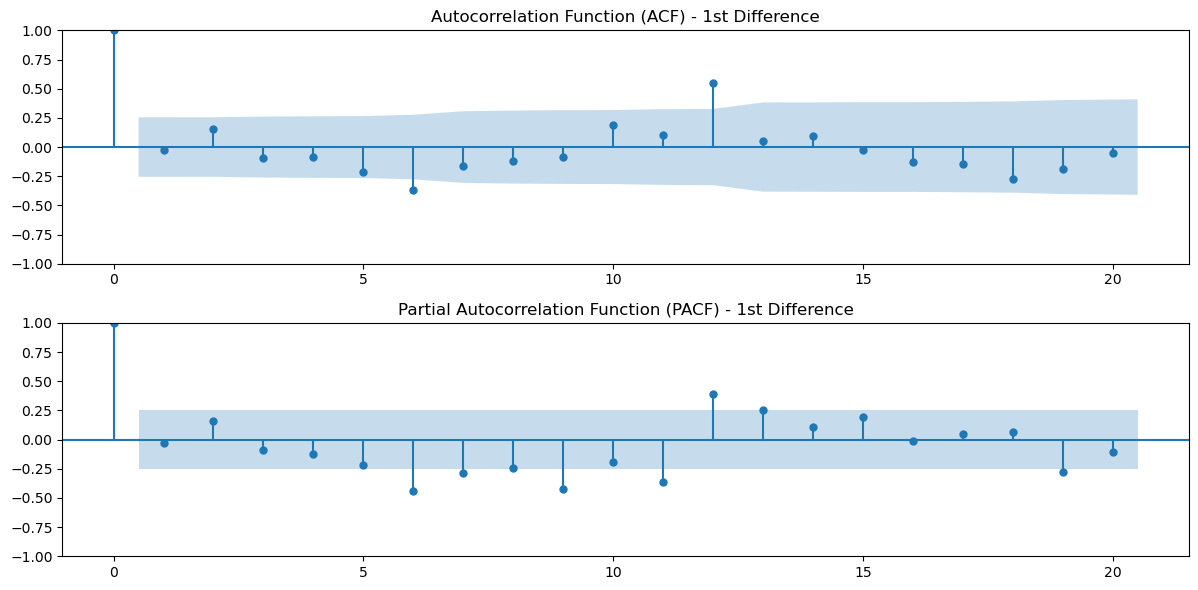

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_h_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_h_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_h_diff)

ADF Statistics: -8.916466740826941
p- value: 1.0693903940841229e-14
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_h[:57]
test=sales_h[57:]

In [15]:
len(train)

57

In [16]:
#therefore, the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(0,1,1),(0,1,2),(1,1,0),(1,1,1),(1,1,2),(2,1,0), (2,1,1), (2, 1, 2),(3,1,0),(3,1,1),(3,1,2),(4,1,0),(4,1,1),(4,1,2),(5,1,0),(5,1,1),(5,1,2)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_h, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_h)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
14  4  2  1281.528274  1295.705736  29209.341771  9.854430e+08  31391.765948
11  3  2  1282.164378  1294.316488  30244.831393  1.054264e+09  32469.436371
17  5  2  1282.249832  1298.452645  28676.020144  9.381431e+08  30629.122094
16  5  1  1287.509866  1301.687328  35123.369596  1.412336e+09  37581.063775
10  3  1  1287.810968  1297.937727  43472.410493  2.148119e+09  46347.802249
13  4  1  1288.219171  1300.371282  39096.480949  1.751715e+09  41853.491926
4   1  1  1291.029674  1297.105729  52912.883016  3.132988e+09  55973.098214
0   0  0  1293.948840  1295.974192  57489.333333  3.689760e+09  60743.395323
8   2  2  1294.695762  1304.822520  56746.727707  3.616469e+09  60137.088132
3   1  0  1295.803444  1299.854147  57669.876409  3.710406e+09  60913.101691
1   0  1  1295.837995  1299.888698  57642.481863  3.707392e+09  60888.359672
6   2  0  1296.416600  1302.492655  56347.925872  3.549034e+09  59573.768041

In [20]:
m_arima= ARIMA (train, order=(4,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   57
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -633.764
Date:                Thu, 09 May 2024   AIC                           1281.528
Time:                        18:14:33   BIC                           1295.706
Sample:                    01-01-2019   HQIC                          1287.025
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2757      0.268      4.755      0.000       0.750       1.802
ar.L2         -0.3169      0.352     -0.900      0.368      -1.007       0.373
ar.L3         -0.2755      0.340     -0.810      0.4

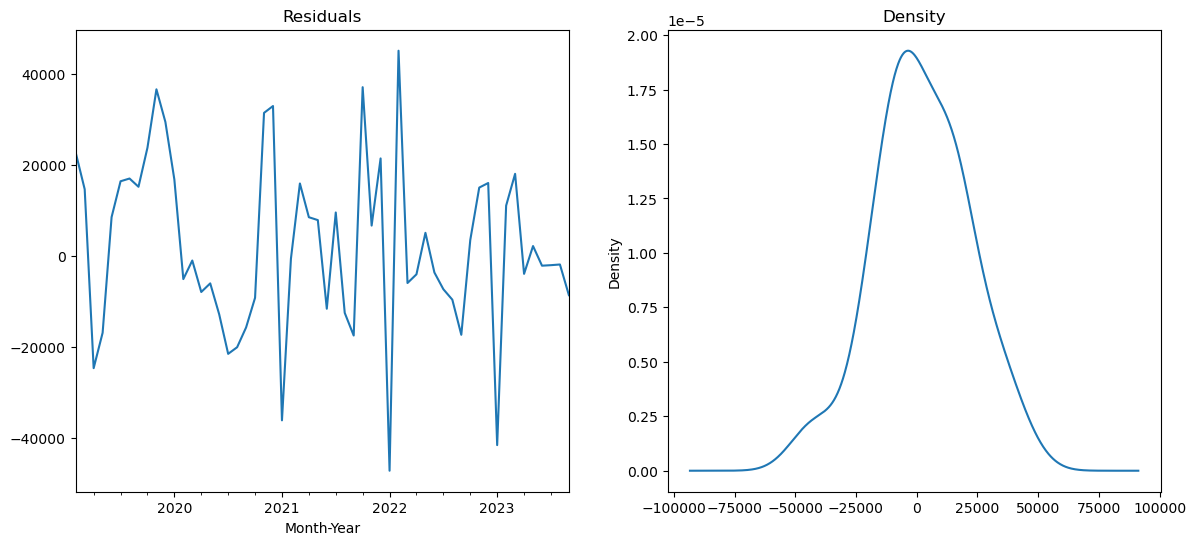

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

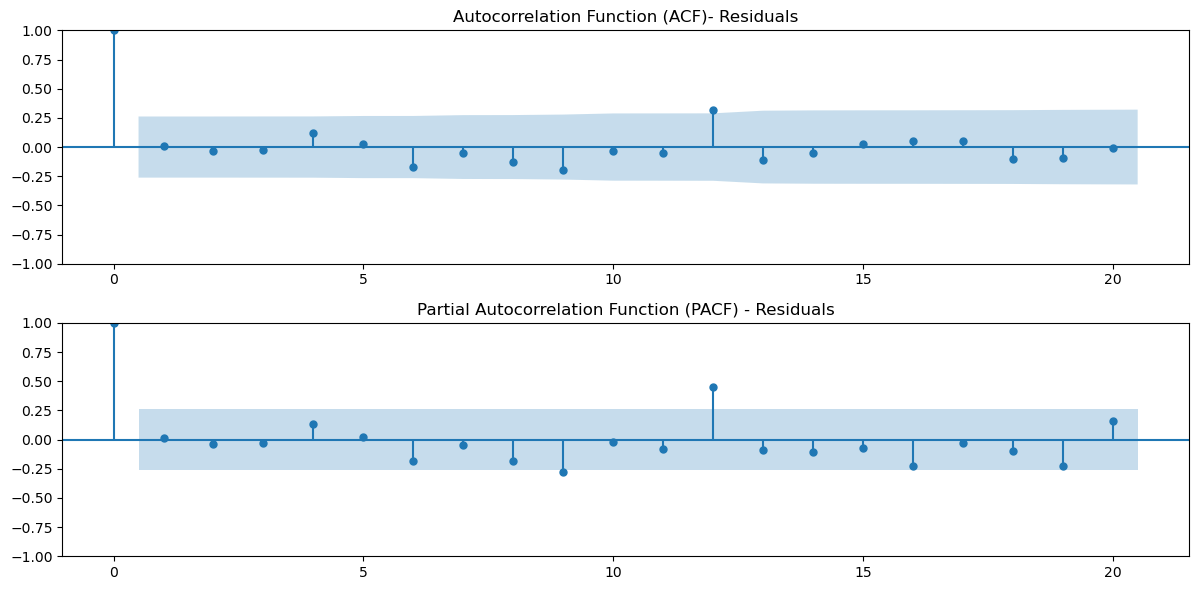

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

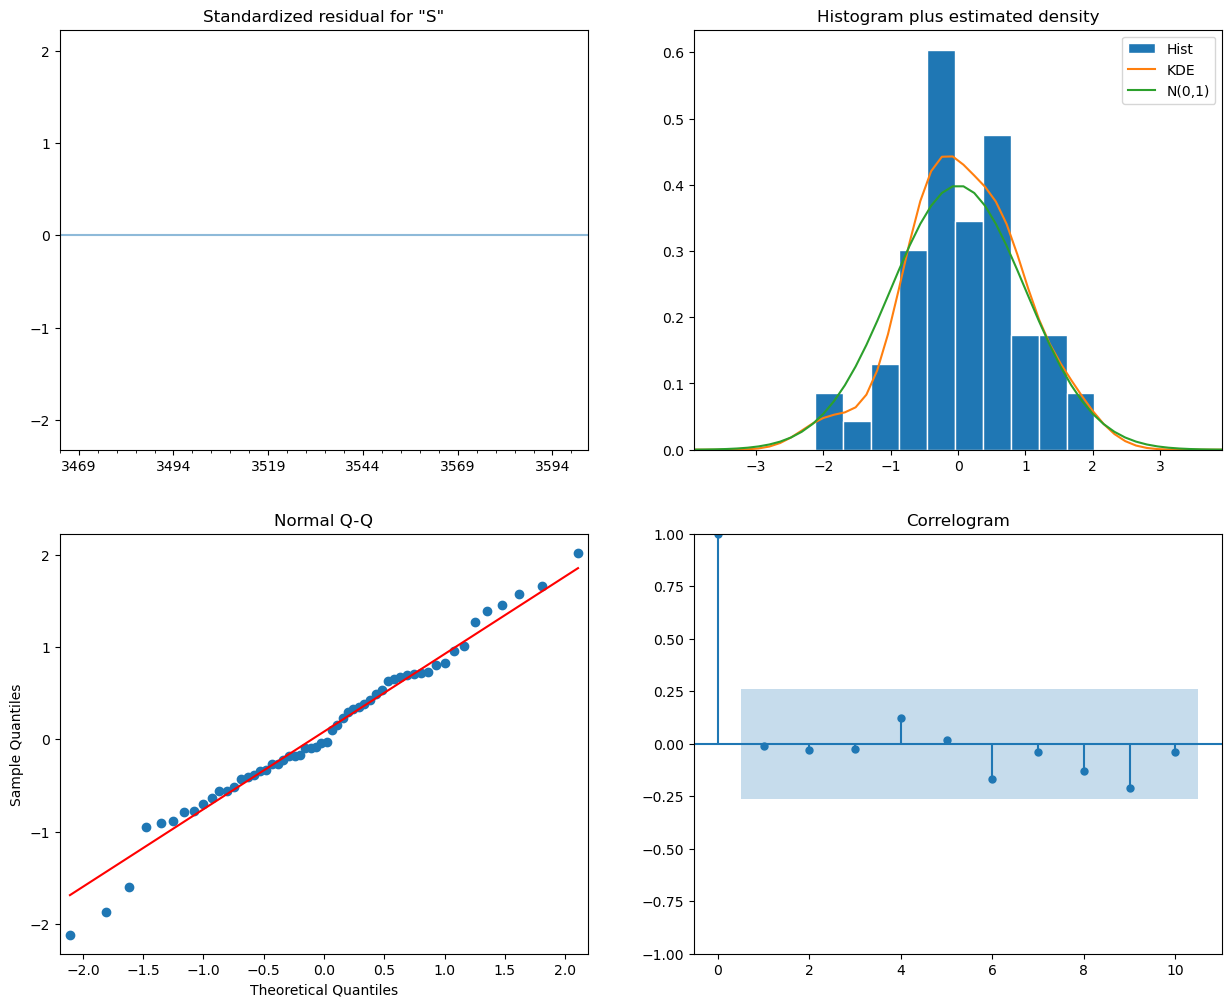

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_h['Forecast_ARIMA']=[None]*len(train) + list(pred)
#plt.figure(figsize=(14, 6))
#sales_h.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_h)-1), dynamic = True)
sales_h['Forecast_ARIMA']=[None]*len(train) + list(pred)

Text(0.5, 1.0, 'Product H')

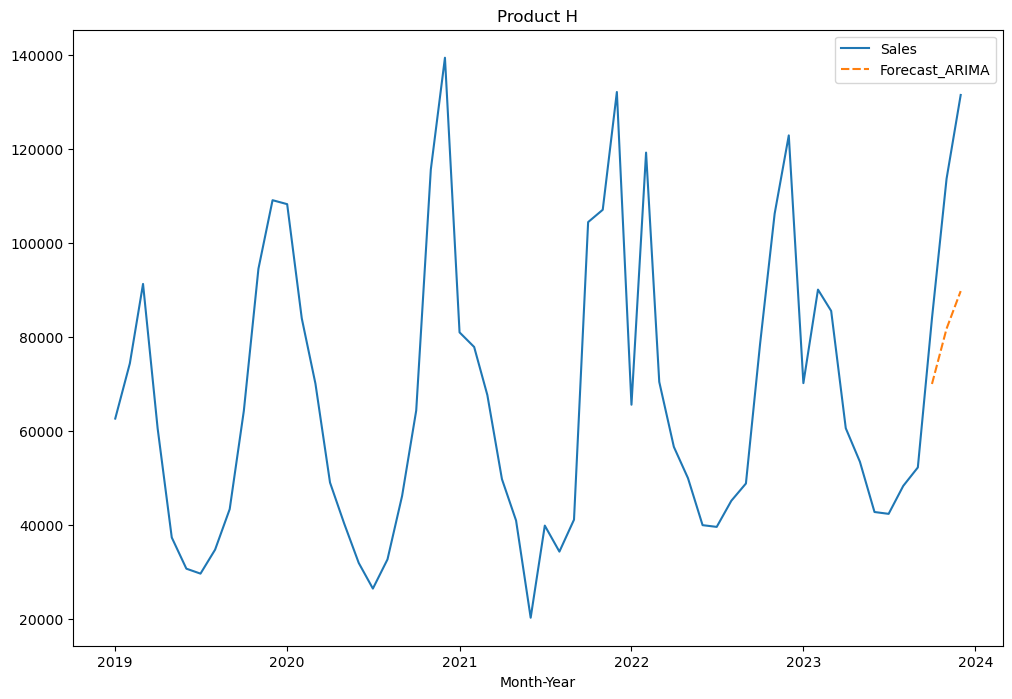

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h)
plt.title('Product H')

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 29209.341771450694
MAPE - ARIMA: 0.25470646931206126
MSE - ARIMA: 985442969.3269691
RMSE - ARIMA: 31391.76594788782


# SARIMA

In [28]:
import statsmodels.api as sm

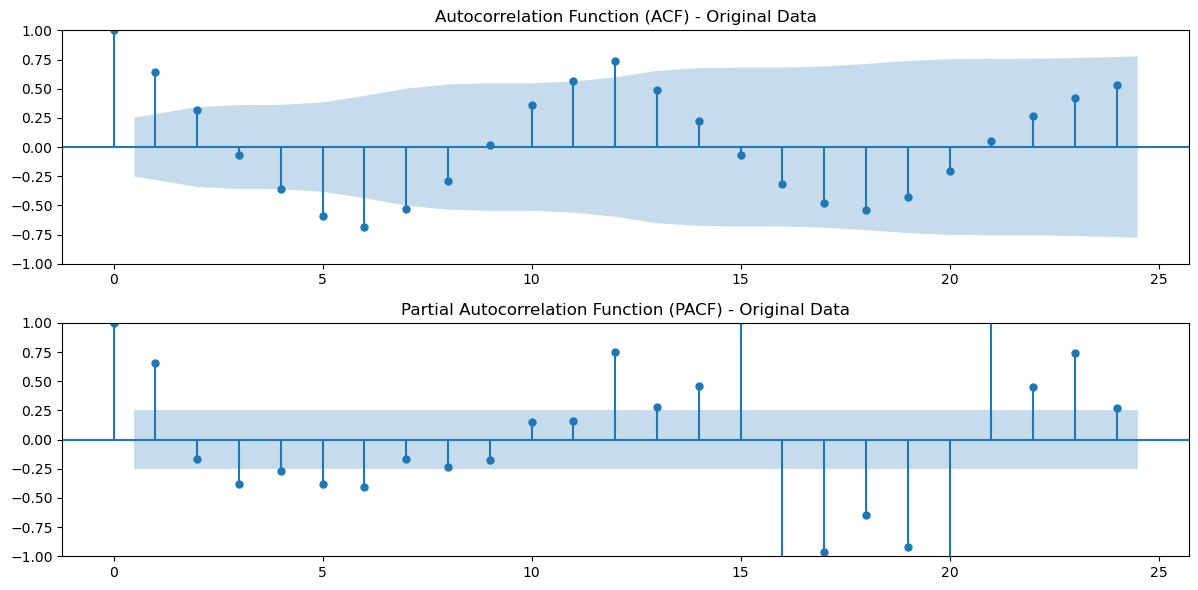

In [29]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_h['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_h['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

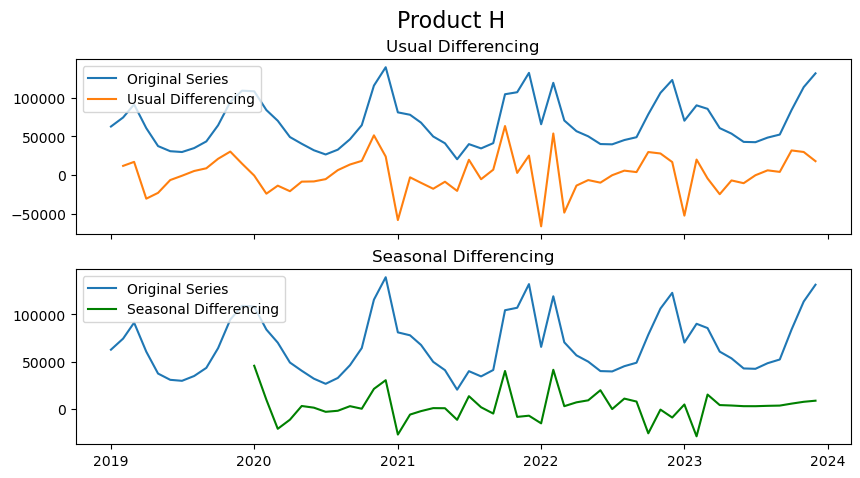

In [30]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_h['Sales'], label='Original Series')
axes[0].plot(sales_h['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_h['Sales'], label='Original Series')
axes[1].plot(sales_h['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product H', fontsize=16)
plt.show()

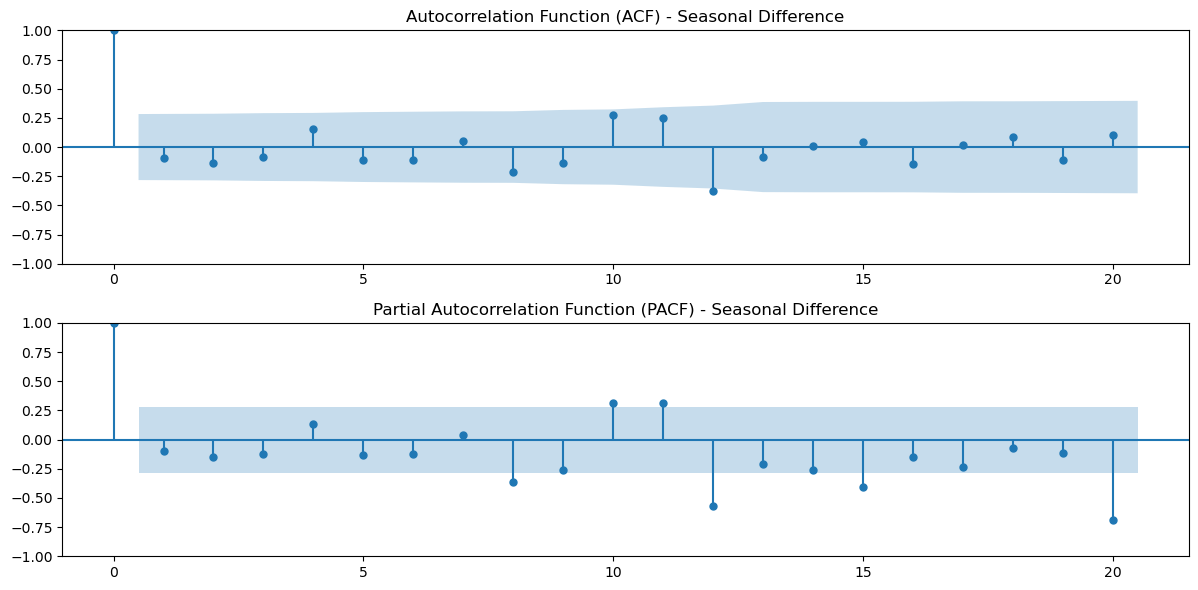

In [31]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_h['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_h['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

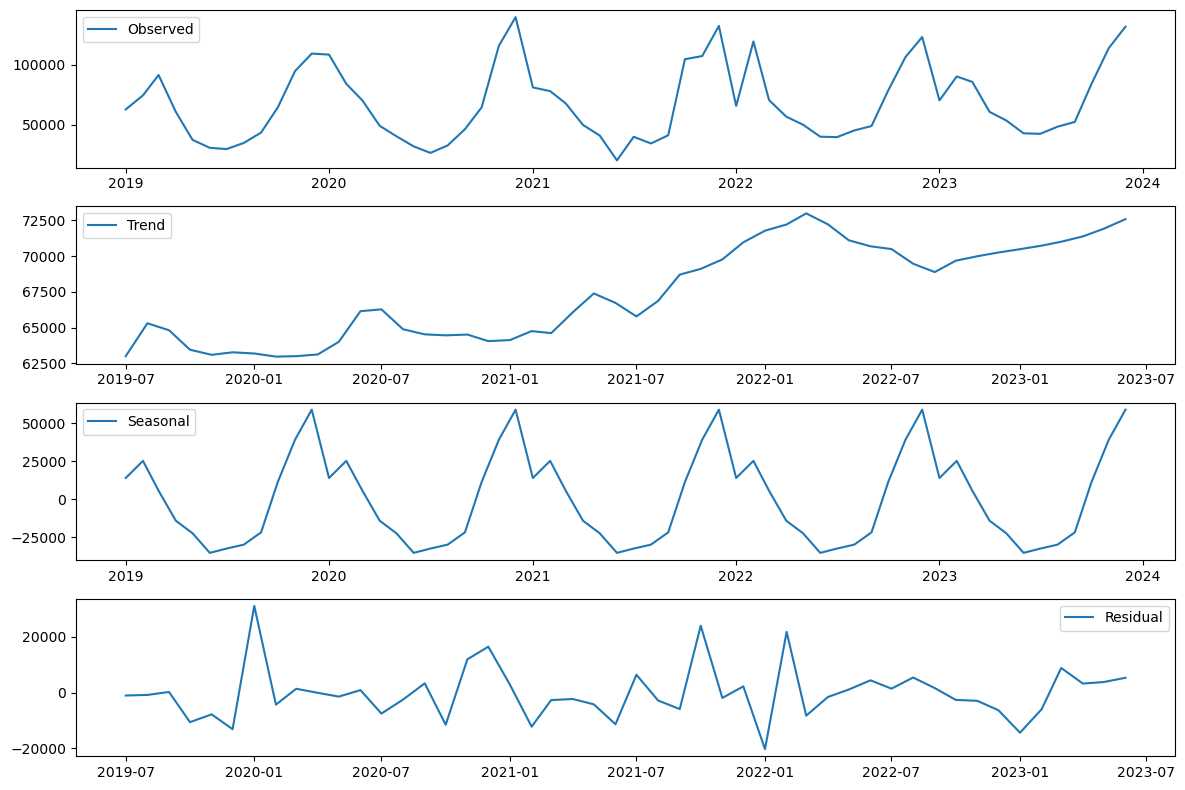

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_h['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [33]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(2):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(4, 1, 2), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=57, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [34]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q          aic          bic           mae           mse
3   1  1  1011.743839  1027.801546   8225.951893  7.763538e+07
8   4  0  1011.805499  1031.431585  32342.454390  1.149991e+09
5   2  1  1011.910241  1029.752137  13831.350457  1.936056e+08
7   3  1  1013.620730  1033.246816  15783.942599  2.606511e+08
10  5  0  1013.805444  1035.215720  32353.020416  1.150774e+09
9   4  1  1013.805447  1035.215722  32356.983519  1.151104e+09
4   2  0  1014.266508  1030.324215   3099.827182  1.919892e+07
6   3  0  1015.020183  1032.862079   4756.620953  2.536526e+07
1   0  1  1015.683216  1029.956733   2658.783680  8.437934e+06
11  5  1  1015.805452  1038.999917  32352.254684  1.150751e+09
2   1  0  1017.680636  1031.954154   3454.591479  1.196379e+07
0   0  0  1018.215207  1030.704534   4484.826422  2.213621e+07


In [35]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(4, 1, 2),seasonal_order=(1,1,1,12))
sarima_model=sarima.fit()

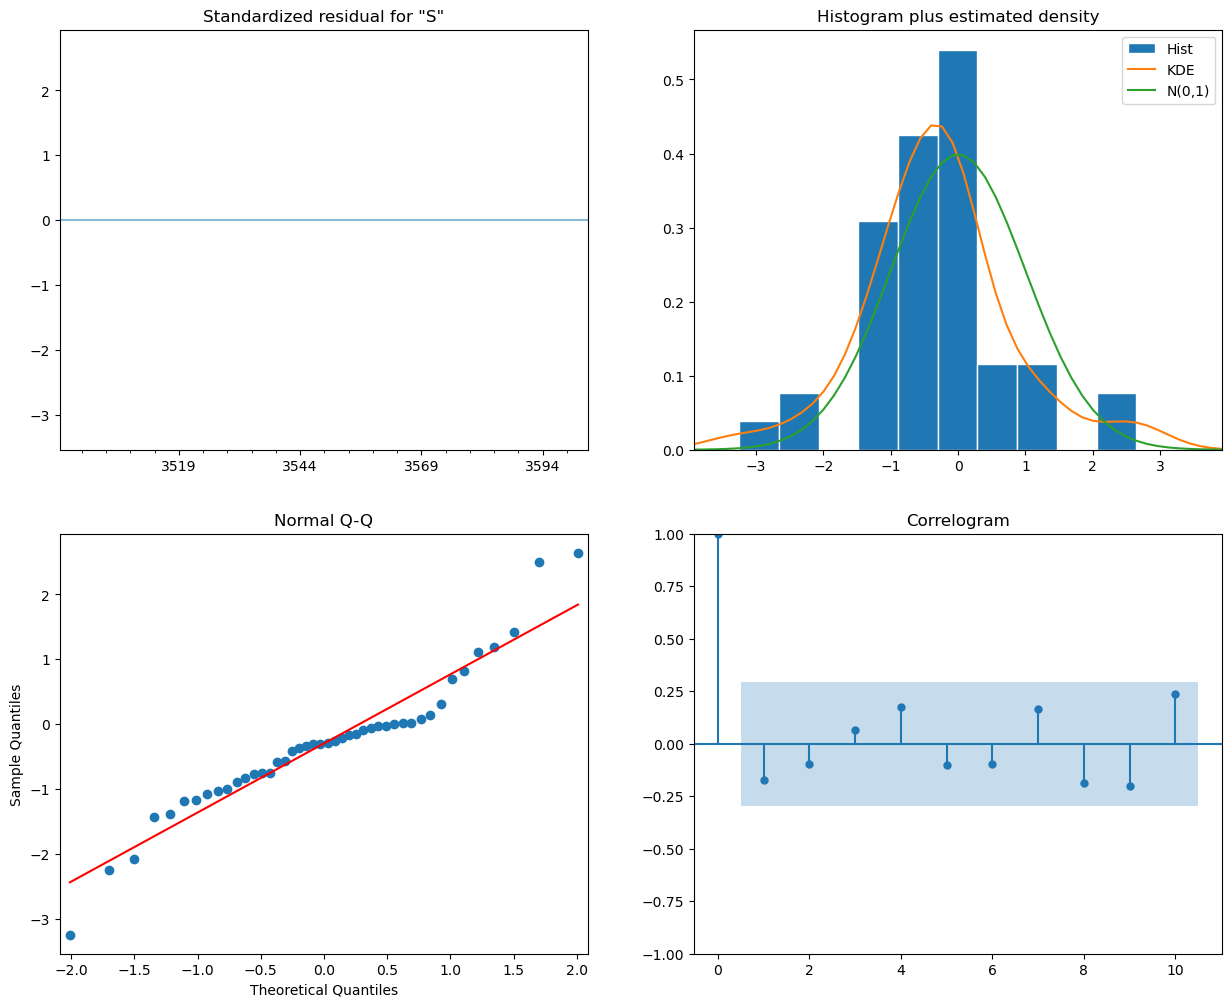

In [36]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [37]:
forecast_test_sarima=sarima_model.predict(start=57,end=59,dynamic=True)

In [38]:
sales_h['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product H')

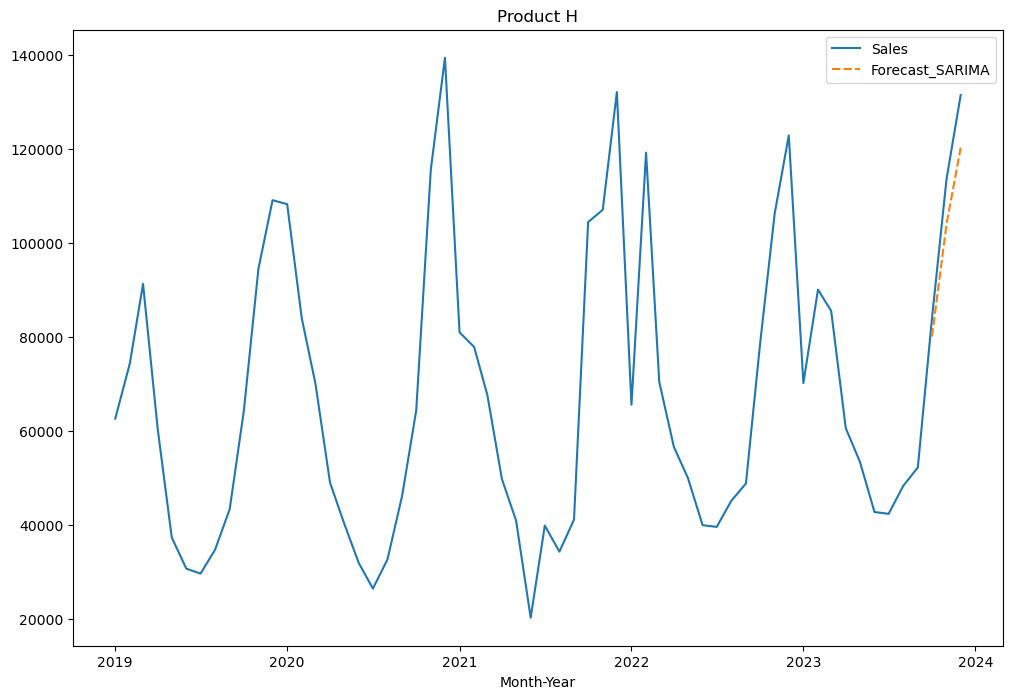

In [39]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h[['Sales','Forecast_SARIMA']])
plt.title('Product H')

In [40]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 8225.952
MAPE - SARIMA: 0.072
MSE - SARIMA: 77635375.844
RMSE - SARIMA: 8811.094


# AUTO-ARIMA

In [41]:
import pmdarima as pm

In [42]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=2,
                          start_P=0, D=1, start_Q=0, max_P=6 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1011.348, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1008.781, Time=0.59 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1008.320, Time=0.57 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1011.177, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1010.103, Time=0.87 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1012.223, Time=0.36 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1011.566, Time=1.72 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=inf, Time=9.49 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=10.17 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=1013.453, Time=6.44 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=1011.789, Time=2.79 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=1013.555, Time=5.17 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1013.789, Time=6.50 sec
 ARIMA(0,1,1)(

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [43]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   57
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -497.987
Date:                                 Thu, 09 May 2024   AIC                           1003.973
Time:                                         18:24:24   BIC                           1011.110
Sample:                                     01-01-2019   HQIC                          1006.620
                                          - 09-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3220      0.116     -2.768      0.006      -0.550      -0.094
ma.S.L12      -0.3314      0.176     -1.879      0.060      -0.677       0.014
ma.S.L24      -0.3093      0.129     -2.400      0.016      -0.562      -0.057
sigma2      3.939e+08   1.89e-10   2.08e+18      0.000    3.94e+08    3.94e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):                 2.18
Prob(Q):                              0.27   Prob(JB):                         0.34
Heteroskedasticity (H):               0.28   Skew:                            -0.09
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.81e+33. Standard errors may be unstable.
"""

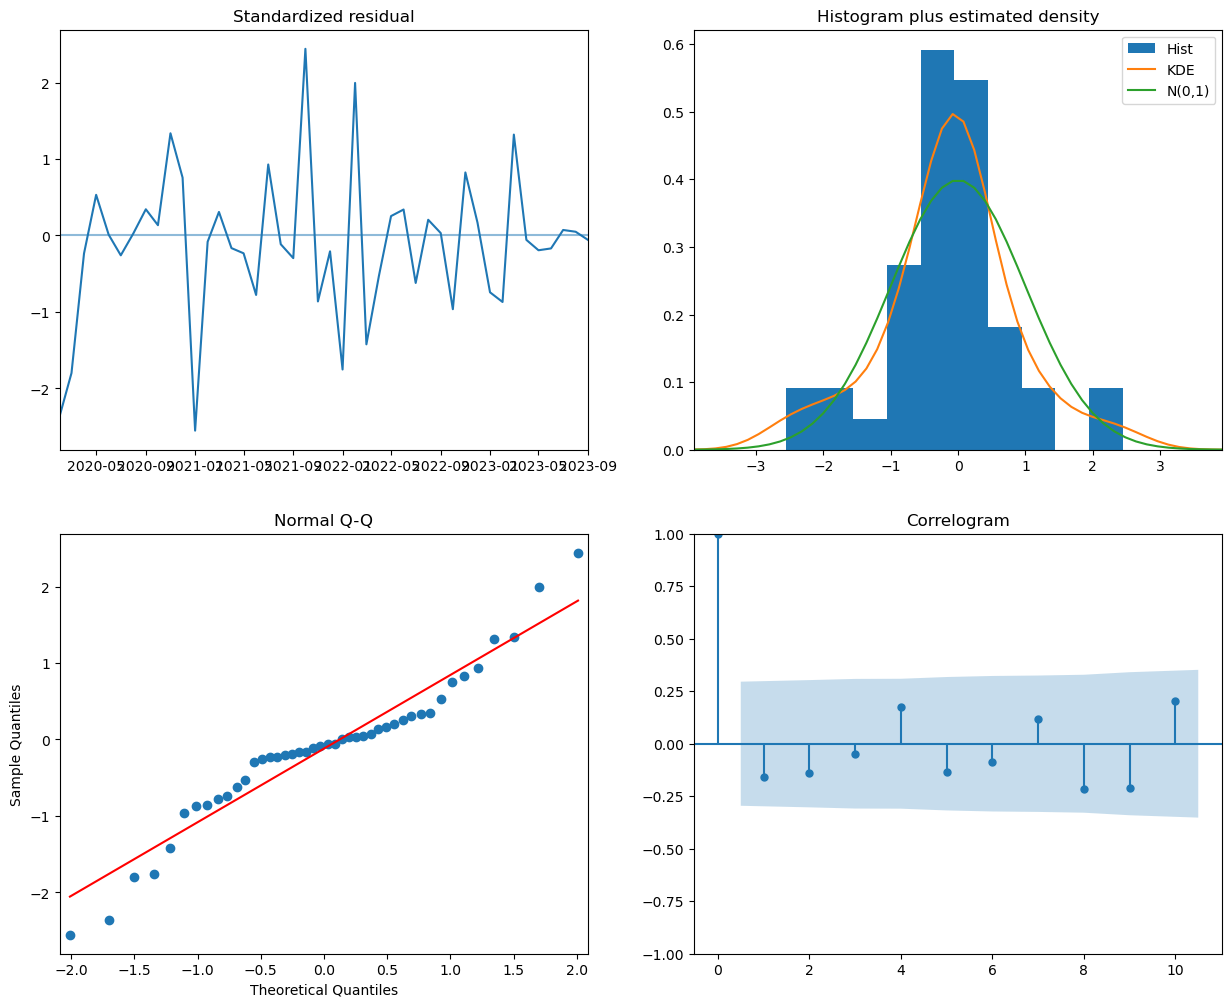

In [44]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [45]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_h['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_h.plot()

Text(0.5, 1.0, 'Product H')

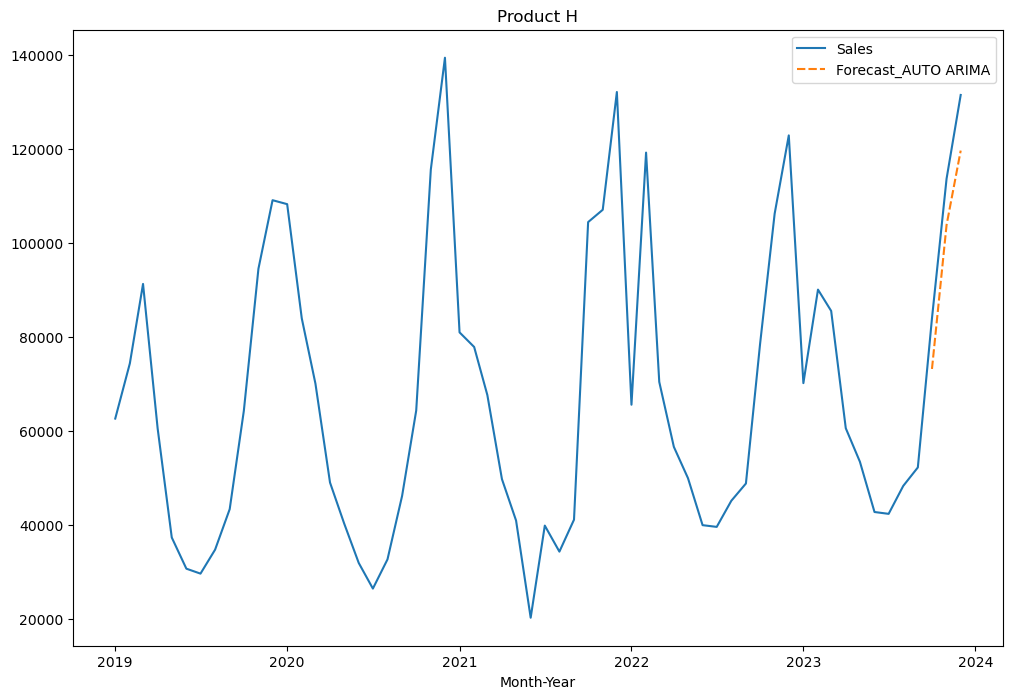

In [46]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product H')

In [47]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 10816.480568599805
MAPE - AUTO ARIMA: 0.10155632824218297
MSE - AUTO ARIMA: 117663269.30415525
RMSE - AUTO ARIMA: 10847.270131427318


In [48]:
sales_h.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,70232,NaN,NaN,NaN
2023-02-01,90139,NaN,NaN,NaN
2023-03-01,85600,NaN,NaN,NaN
2023-04-01,60633,NaN,NaN,NaN
2023-05-01,53500,NaN,NaN,NaN
2023-06-01,42800,NaN,NaN,NaN
2023-07-01,42408,NaN,NaN,NaN
2023-08-01,48352,NaN,NaN,NaN
2023-09-01,52288,NaN,NaN,NaN


In [49]:
sales_h.mean()

Sales                   67632.216667
Forecast_ARIMA          80567.991562
Forecast_SARIMA        101551.381440
Forecast_AUTO ARIMA     98960.852765
dtype: float64

In [50]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,29209.341771,0.254706,9.854430e+08,31391.765948
AUTO ARIMA,10816.480569,0.101556,1.176633e+08,10847.270131
SEASONAL ARIMA,8225.951893,0.071866,7.763538e+07,8811.093907


# TESTING

In [16]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=6,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1001.978, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1003.977, Time=0.07 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=1004.663, Time=0.22 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1003.977, Time=0.14 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1005.664, Time=0.23 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1004.797, Time=0.38 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=1004.246, Time=0.73 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=1005.986, Time=1.36 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1002.903, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1004.832, Time=0.15 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1005.473, Time=0.43 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1004.846, Time=0.18 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,0

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [17]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   57
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -498.989
Date:                  Wed, 08 May 2024   AIC                           1001.978
Time:                          19:54:22   BIC                           1005.591
Sample:                      01-01-2019   HQIC                          1003.325
                           - 09-01-2023                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2680.4667   2528.759      1.060      0.289   -2275.809    7636.743
sigma2      2.506e+08   4.56e+07      5.491      0.000    1.61e+08     3.4e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                 5.16
Prob(Q):                              0.48   Prob(JB):                         0.08
Heteroskedasticity (H):               0.47   Skew:                             0.63
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_h['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product H')

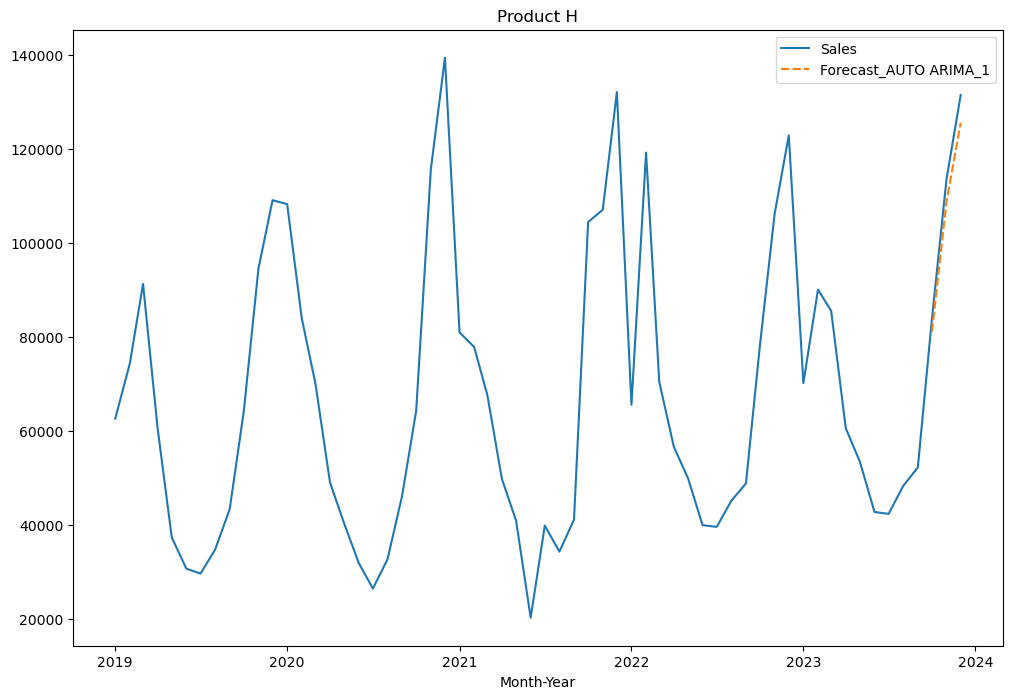

In [19]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product H')

In [20]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 4501.533333333345
MAPE - AUTO ARIMA: 0.04014278744349523
MSE - AUTO ARIMA: 21910396.35111123
RMSE - AUTO ARIMA: 4680.854233055247
